In [16]:
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix
import torch.nn.functional as F


In [71]:
import torch
import numpy as np

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import KFold

from torch.utils.data import DataLoader, ConcatDataset

In [36]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [33]:
# Check if CUDA is available
train_on_gpu = torch.cuda.is_available()
   
if train_on_gpu:
    print("CUDA is available! Training on GPU...")
else:
    print("CUDA is not available. Training on CPU...")

CUDA is available! Training on GPU...


In [3]:
# # Download and split data into train set and test set
# def load_data():
#     transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#     trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
#     testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
#     trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
#     testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)
#     return trainloader, testloader

# trainloader, testloader = load_data()

100%|██████████| 170498071/170498071 [01:05<00:00, 2621627.98it/s]


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [30]:
# Number of subprocesses to use for data loading
num_workers = 0

# How many samples per batch to load
batch_size = 20

# Percentage of training set to use as validation
n_valid = 0.2

# Convert data to a normalized torch.FloatTensor
# Data augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # randomly flip and rotate
    transforms.RandomRotation(10),
                                transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

# Select training_set and testing_set
train_data = datasets.CIFAR10("data", 
                              train= True,
                             download=True,
                             transform = transform)

test_data = datasets.CIFAR10("data", 
                              train= False,
                             download=True,
                             transform = transform)

# Get indices for training_set and validation_set
n_train = len(train_data)
indices = list(range(n_train))
np.random.shuffle(indices)
split = int(np.floor(n_valid * n_train))
train_idx, valid_idx = indices[split:], indices[:split]

# Define samplers for obtaining training and validation
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Prepare data loaders (combine dataset and sampler)
trainloader = torch.utils.data.DataLoader(train_data, 
                                           batch_size = batch_size,
                                          sampler = train_sampler,
                                          num_workers = num_workers)    

validloader = torch.utils.data.DataLoader(train_data, 
                                           batch_size = batch_size,
                                          sampler = valid_sampler,
                                          num_workers = num_workers)

testloader = torch.utils.data.DataLoader(test_data, 
                                           batch_size = batch_size,
                                          num_workers = num_workers)

Files already downloaded and verified
Files already downloaded and verified


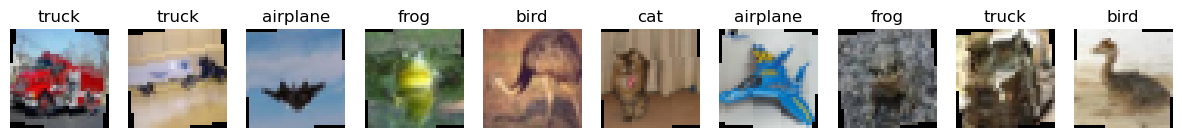

In [29]:
# Visualize images from dataset
def visualize_images():
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    
    # Iterate over trainloader to get images and labels
    for images, labels in trainloader:
        break  # Break after the first batch

    fig, axes = plt.subplots(1, 10, figsize=(15, 15))
    for idx, (img, label) in enumerate(zip(images[:10], labels[:10])):
        img = img / 2 + 0.5  # unnormalize
        npimg = img.numpy()
        ax = axes[idx]
        ax.imshow(np.transpose(npimg, (1, 2, 0)))
        ax.set_title(class_names[label.item()])
        ax.axis('off')
    plt.show()

visualize_images()


In [47]:
# Define your model
class BasicModel(nn.Module):
    def __init__(self):
        super(BasicModel, self).__init__()
        #Convolutional Layers
                                #Init_chanels, chanels, kernel size, padding 
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        
        #Pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        #FC layers
        self.fc1 = nn.Linear(64 * 4 * 4, 512)  #
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        # Flatten the image
        x = x.view(-1, 64 * 4 * 4)  # Flatten the output
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [65]:
class DropoutModel(nn.Module):
    def __init__(self):
        super(DropoutModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        
        # Pooling layers
        self.pool = nn.MaxPool2d(2,2)
        
        # FC layers
        # Linear layer (64x4x4 -> 500)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        
        # Linear Layer (500 -> 10)
        self.fc2 = nn.Linear(500, 10)
        
        # Dropout layer
        self.dropout = nn.Dropout(0.25)
        
    def forward(self, x):
        x = self.pool(F.elu(self.conv1(x)))
        x = self.pool(F.elu(self.conv2(x)))
        x = self.pool(F.elu(self.conv3(x)))
        
        # Flatten the image
        x = x.view(-1, 64*4*4)
        x = self.dropout(x)
        x = F.elu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [41]:
import torch.nn.functional as F

# Training function
def train_model(net, namept, epochs=5):
    net = net.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    train_acc = []
    val_acc = []
    train_loss = []
    val_loss = []
    valid_loss_min = np.Inf  # Initialize minimum validation loss

    for epoch in range(epochs):
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Training phase
        net.train()
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        # Calculate training accuracy and loss
        train_loss.append(running_loss / len(trainloader))
        train_acc.append(100 * correct_train / total_train)

        # Validation phase
        correct_val = 0
        total_val = 0
        val_running_loss = 0.0
        net.eval()
        with torch.no_grad():
            for inputs, labels in validloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        # Calculate validation accuracy and loss
        val_loss.append(val_running_loss / len(validloader))
        val_acc.append(100 * correct_val / total_val)

        # Calculate average losses
        train_loss_epoch = train_loss[-1] / len(trainloader.dataset)
        val_loss_epoch = val_loss[-1] / len(validloader.dataset)

        # Print epoch-wise statistics
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss_epoch}, Train Acc: {train_acc[-1]}, Val Loss: {val_loss_epoch}, Val Acc: {val_acc[-1]}")

        # Save model if validation loss has decreased
        if val_loss_epoch <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min,
                val_loss_epoch))
            torch.save(net.state_dict(), namept)
            valid_loss_min = val_loss_epoch

    return train_acc, val_acc, train_loss, val_loss




In [32]:

# Plot the result after fitting
def plot_result(train_acc, val_acc, train_loss, val_loss):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    # summarize history for accuracy
    axs[0].plot(train_acc, label='train')
    axs[0].plot(val_acc, label='validate')
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(loc='upper left')
    # summarize history for loss
    axs[1].plot(train_loss, label='train')
    axs[1].plot(val_loss, label='validate')
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(loc='upper left')
    plt.show()

In [48]:
# Train and evaluate basic model
basic_model = BasicModel()
print(basic_model)

# Move tensors to GPU is CUDA is available
if train_on_gpu:
    basic_model.cuda()


BasicModel(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


Epoch 1/5, Train Loss: 1.3652538996189834e-05, Train Acc: 75.85, Val Loss: 1.6349554808735848e-05, Val Acc: 72.42
Validation loss decreased (inf --> 0.000016).  Saving model ...
Epoch 2/5, Train Loss: 1.293826201930642e-05, Train Acc: 77.2575, Val Loss: 1.67140984582901e-05, Val Acc: 71.61
Epoch 3/5, Train Loss: 1.245967250496149e-05, Train Acc: 78.0675, Val Loss: 1.6154929929971696e-05, Val Acc: 73.06
Validation loss decreased (0.000016 --> 0.000016).  Saving model ...
Epoch 4/5, Train Loss: 1.1947546145617962e-05, Train Acc: 79.0325, Val Loss: 1.642670445263386e-05, Val Acc: 72.32
Epoch 5/5, Train Loss: 1.1399808137938381e-05, Train Acc: 79.9175, Val Loss: 1.601494240820408e-05, Val Acc: 73.62
Validation loss decreased (0.000016 --> 0.000016).  Saving model ...


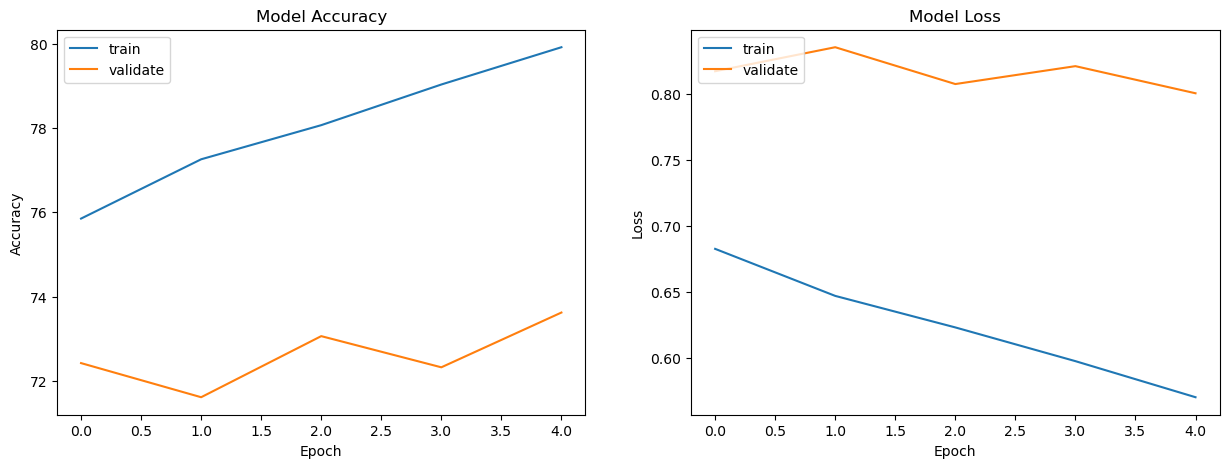

In [67]:
namept = "model_cifar.pt"
train_acc, val_acc, train_loss, val_loss = train_model(basic_model,  namept,epochs=5)
plot_result(train_acc, val_acc, train_loss, val_loss)

Epoch 1/5, Train Loss: 2.8350514825582503e-05, Train Acc: 48.9, Val Loss: 2.336494116544724e-05, Val Acc: 59.05
Validation loss decreased (inf --> 0.000023).  Saving model ...
Epoch 2/5, Train Loss: 2.3191044333279132e-05, Train Acc: 58.945, Val Loss: 2.0757579293251038e-05, Val Acc: 62.88
Validation loss decreased (0.000023 --> 0.000021).  Saving model ...
Epoch 3/5, Train Loss: 2.1176497957408426e-05, Train Acc: 62.6825, Val Loss: 1.9139704352617265e-05, Val Acc: 65.75
Validation loss decreased (0.000021 --> 0.000019).  Saving model ...
Epoch 4/5, Train Loss: 1.9703736598789692e-05, Train Acc: 65.6525, Val Loss: 1.828986542582512e-05, Val Acc: 67.75
Validation loss decreased (0.000019 --> 0.000018).  Saving model ...
Epoch 5/5, Train Loss: 1.8751419915258883e-05, Train Acc: 67.4375, Val Loss: 1.826952684521675e-05, Val Acc: 68.28
Validation loss decreased (0.000018 --> 0.000018).  Saving model ...


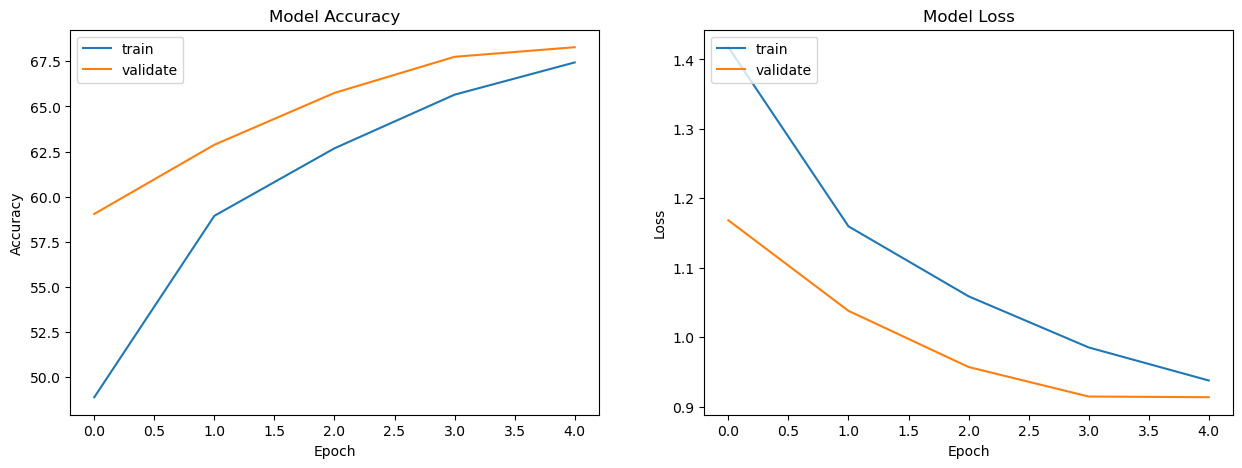

In [66]:

# Train and evaluate dropout model
dropout_model = DropoutModel()
train_acc, val_acc, train_loss, val_loss = train_model(dropout_model, "model_droped.pt",epochs=5)
plot_result(train_acc, val_acc, train_loss, val_loss)

In [70]:
dropout_model.__dict__

{'training': False,
 '_parameters': OrderedDict(),
 '_buffers': OrderedDict(),
 '_non_persistent_buffers_set': set(),
 '_backward_pre_hooks': OrderedDict(),
 '_backward_hooks': OrderedDict(),
 '_is_full_backward_hook': None,
 '_forward_hooks': OrderedDict(),
 '_forward_hooks_with_kwargs': OrderedDict(),
 '_forward_hooks_always_called': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_forward_pre_hooks_with_kwargs': OrderedDict(),
 '_state_dict_hooks': OrderedDict(),
 '_state_dict_pre_hooks': OrderedDict(),
 '_load_state_dict_pre_hooks': OrderedDict(),
 '_load_state_dict_post_hooks': OrderedDict(),
 '_modules': OrderedDict([('conv1',
               Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
              ('conv2',
               Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
              ('conv3',
               Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
              ('pool',
               MaxPool2d(kernel_s

## 3. A model applied K-Fold Validation

In [89]:
concat_dataset = ConcatDataset([train_data, test_data])

In [90]:

num_epochs = 5
batch_size = 64
learning_rate = 0.001


In [92]:
# Define k-fold
kfold = KFold(n_splits=5, shuffle=True)

# Training loop with k-fold cross-validation
for fold, (train_idx, val_idx) in enumerate(kfold.split(concat_dataset)):
    print(f"Fold {fold+1}")

    # Create DataLoader for training and validation
    train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)

    trainloader = torch.utils.data.DataLoader(concat_dataset, batch_size=batch_size, sampler=train_sampler)
    
    validloader = torch.utils.data.DataLoader(concat_dataset, batch_size=batch_size, sampler=val_sampler)

    # print(type(trainloader))
    # Define your model
    model = BasicModel()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    train_acc_history, val_acc_history = [], []
    train_loss_history, val_loss_history = [], []

    # Training loop for each fold
    # Training phase
    model.train()
    for i, data in enumerate(trainloader, 0):
        # print("hell")
        inputs, labels = data

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        if i % 100 == 99:    # Print every 100 mini-batches
            print(f'[{fold+1}, {i+1}] loss: {current_loss / 100:.3f}')
            current_loss = 0.0

        # Validation phase
        model.eval()
        with torch.no_grad():
            total_train = 0
            correct_train = 0
            train_loss = 0.0
            for data in trainloader:
                images, labels = data
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()
                loss = criterion(outputs, labels)
                train_loss += loss.item()
                
            train_accuracy = correct_train / total_train
            train_loss /= len(trainloader)
            train_acc_history.append(train_accuracy)
            train_loss_history.append(train_loss)

            total_val = 0
            correct_val = 0
            val_loss = 0.0
            for data in validloader:
                images, labels = data
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
            val_accuracy = correct_val / total_val
            val_loss /= len(validloader)
            val_acc_history.append(val_accuracy)
            val_loss_history.append(val_loss)

    # Plot results for the fold
    plot_result(train_acc_history, val_acc_history, train_loss_history, val_loss_history)

Fold 1
<class 'torch.utils.data.dataloader.DataLoader'>


KeyboardInterrupt: 